# Projet de réseau de neurones
>Sujet: **Entrainement d'un réseau de neurones sur des commandes vocales courtes**

Nous avons cherché un dataset d'extrait audio de qualité plutôt qu'enregistrer nous même les commandes. (Cela aurait demandé beaucoup trop de temps et un matériel et studio dont nous ne disposons pas.)

Nous avons trouvé un dataset réalisé et mis à disposition par TensorFlow et AIY : [Speech_commands](https://www.tensorflow.org/datasets/catalog/speech_commands) ([Présentation Google blog](https://ai.googleblog.com/2017/08/launching-speech-commands-dataset.html))

Nous avons téléchargé, transformé, selectionné et séparé nous même les données en ensemble pour notre propre réseau de neurones. Nous avons cherché à optimiser nos resultats sans sur-entrainer le réseaux au sets fournis en entrée.


Ce Dataset rassemble plusieurs milliers d'enregistrements pour 35 mots clés, dont un extrait ci-dessous :

- down,  go,  left,  no,  right,  stop,  up,  yes

Pour entrainer notre modèle, nous transformons chacun des extraits audio d'une taille fixe en spectrogramme. Cette transformation nous permet de le traiter comme nous traitons une image dans le réseau de neurone.

## 0 - Importation des librairies

In [35]:
import os

import torch
import numpy

# pour charger le dataset, dataloader etc
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split

# pour les transformations sur les extraits audio
import torchaudio 

# Téléchargement et extraction du dossier contenant les extraits audio
import urllib
import zipfile
import tarfile

# Affichage des extraits audio
import IPython 
import matplotlib.pyplot as plt
import numpy as np
import librosa
import librosa.display
import math

# construction du réseau de neurones
from torch import nn

# pour les evaluations
from sklearn.metrics import classification_report

## 1 - Le Dataset audio
### Téléchargement du dataset

In [36]:
# Le lien du dataset
url = "http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz"

# Création d'un dossier pour le dataset
current_path = os.path.abspath("voice_control_nn.py")
path_len = len(current_path)
len_to_delete = len("voice_control_nn.py")
current_path = current_path[:(path_len - len_to_delete)]
DIR_PATH = os.path.join(current_path, "biblio")

In [37]:
# Le dataset ne sera téléchargé que si il n'a toujours pas
# été téléchargé
try :
  if (not os.path.exists(DIR_PATH)):
      os.mkdir(DIR_PATH)

      extract_dir = DIR_PATH

      tar_path, _ = urllib.request.urlretrieve(url)
      file = tarfile.open(tar_path)
      # extracting file
      file.extractall(extract_dir)
except (Exception) as e:
  os.remove(DIR_PATH)
  raise e
    
# ATTENTION : Le téléchargement peut prendre un certain temps

Voici quelques extraits téléchargés:
- yes

In [38]:
IPython.display.display(IPython.display.Audio(DIR_PATH+"/yes/0ab3b47d_nohash_0.wav"))

- no

In [39]:
IPython.display.display(IPython.display.Audio(DIR_PATH+"/no/0ab3b47d_nohash_0.wav"))

In [40]:
# Liste des mots clés :
List_word = os.listdir(DIR_PATH)
List_word.remove('LICENSE')
List_word.remove('README.md')
List_word.remove('.DS_Store')
List_word.remove('testing_list.txt')
List_word.remove('validation_list.txt')
print(len(List_word), List_word)

36 ['down', 'cat', 'bird', 'yes', 'one', 'backward', 'zero', 'up', 'sheila', 'house', 'left', 'go', 'three', 'on', 'nine', 'forward', 'six', 'tree', 'seven', 'marvin', 'right', 'off', 'eight', 'follow', 'stop', 'four', 'happy', 'wow', 'visual', '_background_noise_', 'two', 'bed', 'learn', 'dog', 'no', 'five']


In [41]:
# Mot clé que nous traitons :
COMMANDS = ['yes', 'no' ]


### Classe du Dataset
Cette classe contient les fonctions pour:
- Charger les extraits audios
- Uniformiser la sample rate ("résolution" du son) à une valeur cible
- Uniformiser les extraits en terme de temps
- Transformer un signal audio en Mel Spectrogramme

In [42]:
# classe Dataset
class VoiceCommandsDataset(Dataset):
    
    # fonction d'initialisation du dataset
    def __init__(self, 
                 PATH, 
                 COMMANDS, 
                 transformation, 
                 label_transformation,
                 target_SR,
                 num_samples):
        
    
        # liste des noms et chemins de fichier
        self.name_path = []
        # liste des label auquel appartient le fichier de même indexe
        self.labels = []
        # pour chaque dossier associé à une commande
        for dir_name in COMMANDS:
            # pour chaque fichier dans le dossier de la commande
            for filename in os.listdir(os.path.join(PATH, dir_name)):
                self.name_path.append(os.path.join(PATH, dir_name, filename))
                self.labels.append(dir_name)
                
        # transformation qui sera appliquée pour les extraits audios
        # pour les convertirs en mel_spectrogrammes
        self.transformation = transformation
        # Sample Rate pour laquelle on va convertir les extraits
        self.target_SR = target_SR
        #
        self.num_samples = num_samples
                
    
    # retourne le signal d'un extrait audio en le traitant pour
    # qu'il soit utilisable dans le réseau de neurone
    def __getitem__(self, index):
        sample_path = self.name_path[index]
        label = self.labels[index]
        
        # Extraction du signal analogique du .wav 
        # signal -> (num_channels, samples)
        signal, sample_rate = torchaudio.load(sample_path)
        
        ### PROCESSING
        
        # transforme le signal à la sample rate qu'on recherche
        if sample_rate != self.target_SR:
            signal = self._resample(signal, sample_rate)
        
        # transforme le signal en mono si il n'est pas en mono
        if signal.shape[0] > 1:
            signal = self._X_to_mono(signal)
            
        # traitement de la longeur de l'extrait audio
        if signal.shape[1] > self.num_samples:
            signal = self._cut(signal)
        elif signal.shape[1] < self.num_samples:
            signal = self._padd(signal)
        
        # transformation du signal en un mel_spectrogramme
        mel_signal = self.transformation(signal)
        
        # conversion du label
        label = label_transformation(label)
        
        return mel_signal.flatten(), label
    
    # retourne la taille du dataset
    def __len__(self):
        return len(self.labels)
    
    # On coupe la fin du signal pour conformer l'extrait à la taille
    # recherchée
    def _cut(self, signal):
        signal = signal[:, :self.num_samples]
        return signal
    
    # On ajoute des zéros à droite de la structure (fin du son)
    # pour conformer l'extrait à la taille recherchée
    def _padd(self, signal):
        nb_missing_samples = self.num_samples - signal.shape[1]
        padding = (0, nb_missing_samples)
        signal = torch.nn.functional.pad(signal, padding)
        return signal
    
    # converti un signal à la sr cible    
    def _resample(self, signal, sr):
        resampler = torchaudio.transforms.Resample(sr, self.target_SR)
        signal = resampler(signal)
        return signal
        
    
    # converti un son à plusieurs canaux à un son en mono
    def _X_to_mono(self, signal, sr):
        signal = torch.mean(signal, dim=0, keepdim=True)
        return signal
        
        

### Variables

In [43]:
# Paramètres des audios
SAMPLE_RATE = 16000 # ceux des extraits actuels
NUM_SAMPLES = 16000

### Paramètrage du Mel spectrogramme (Spectrogramme mélodique)
Le signal audio que l'on récupère est codé sous forme d'**amplitude sonore** et nous le transformons en **spectrogramme de mel** (du point de vue des décibels) pour se conformer à la perception humaine.

En effet nous ne pouvons pas avoir une perception des changements de fréquence, comparable à celle de l'ouïe humaine, dans les spectrogrammes ordinaires.
L'échelle de Mel est une échelle logarithmique de la fréquence, qui permet d'ajuster la fréquence à celle perçue par un humain. L'unité du Mel est relié au Hz.

> Sources: 
* Fonction transforms : https://pytorch.org/audio/stable/transforms.html
* Fonction MelSpectrogram : https://pytorch.org/audio/stable/generated/torchaudio.transforms.MelSpectrogram.html

In [44]:
# Signal audio -> transformations de fourrier -> spectrogramme -> mel spectrogramme
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate = SAMPLE_RATE,
    n_fft = 1024,     # taille d'une frame
    hop_length = 512, # moitié de la taille d'une frame ###
    n_mels = 64       # nb de filtres de mel -> similaire au learning rate (habituellement entre ~ 40 et 128)
)

### Conversion du label

In [45]:
def label_transformation(label, reference=COMMANDS):
    return reference.index(label)

### Récupération du dataset

In [46]:
vcdataset = VoiceCommandsDataset(DIR_PATH, 
                           COMMANDS, 
                           mel_spectrogram,
                           label_transformation,
                           SAMPLE_RATE,
                           NUM_SAMPLES)

### Tests sur les formats des données

In [47]:
print(f"there are {len(vcdataset.name_path)} samples in the dataset.")
# Il y a 1000 fichiers par commande

signal, label = vcdataset.__getitem__(0)
print(signal.size())

print(vcdataset[14])

signal, label = vcdataset[56]
print(signal.size())

there are 7985 samples in the dataset.
torch.Size([2048])
(tensor([7.1559e-06, 1.8556e-07, 1.0616e-07,  ..., 4.8489e-04, 1.6985e-04,
        2.1529e-06]), 0)
torch.Size([2048])


### Affichage des Signaux analogues vs Spectrogrammes pour 'Yes' et 'No':

In [48]:
# Fonction d'affichage des signaux
# type_s: 0 pour analog, 1 pour spectrogramme 
def plot_nice_pics_of_sound(dataset, dim, command, type_s):
    count_ready_to_plot = 0
    i = 0
    fig, axes = plt.subplots(nrows=dim, ncols=dim, sharex=True, sharey=True, squeeze=False)
    while(count_ready_to_plot != dim*dim):
        l = count_ready_to_plot % dim # ligne
        c = math.floor(count_ready_to_plot/dim) # colonne
        
        signal, sample_rate = torchaudio.load(dataset.name_path[i])
                
        # if it's analog signal
        if (type_s == 0):
            if (command == dataset.labels[i]) :   
                
                nb_chan, nb_frames = signal.shape
                time_axis = torch.arange(0, nb_frames) / SAMPLE_RATE
                axes[l][c].plot(time_axis, signal[0], linewidth=1)
                
                count_ready_to_plot+=1
        
        # si c'est un spectrogramme
        elif (type_s == 1):
            if (command == dataset.labels[i]):
                signal = signal.flatten()
                Mel = librosa.feature.melspectrogram(y=signal.numpy(), sr=sample_rate)
                M_db = librosa.power_to_db(Mel, ref=np.max)
                img = librosa.display.specshow(M_db, y_axis='mel', x_axis='time', ax=axes[l][c])
                #fig.colorbar(img, ax=axes[l][c], format="%+2.f dB")
                
                count_ready_to_plot+=1
                
        else:
            break
        
        i+=1
    plt.show()

# Dimension des matrices de comparaisons de signaux analogues
dimension = 3

- Signal Yes

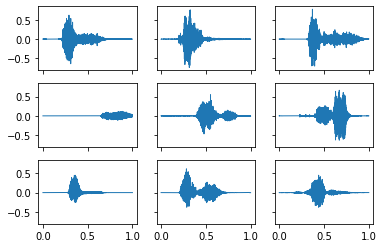

In [49]:
plot_nice_pics_of_sound(vcdataset, dimension, 'yes', 0)

- Signal No

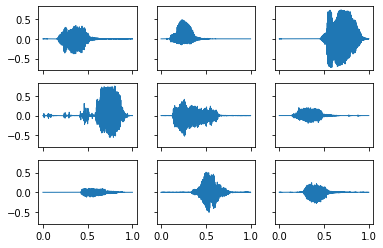

In [50]:
plot_nice_pics_of_sound(vcdataset, dimension, 'no', 0)

- Spectrogramme Yes

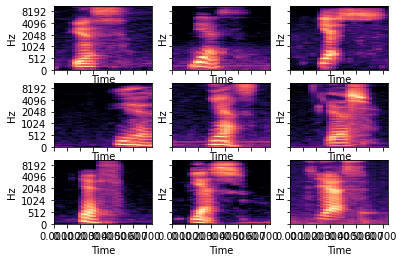

In [51]:
plot_nice_pics_of_sound(vcdataset, dimension, 'yes', 1)

- Spectrogramme No

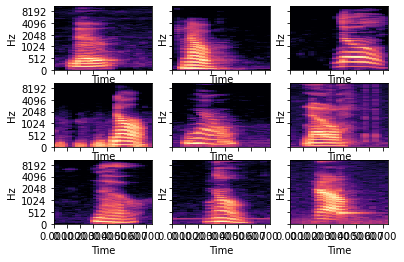

In [52]:
plot_nice_pics_of_sound(vcdataset, dimension, 'no', 1)

### Séparation du Dataset
La séparation du Dataset en Train Set, Validation Set et Test Set se fait aléatoirement avec le ratio 6/8, 1/8, 1/8.

In [53]:
# Création des dataset pour le réseau:
train_dataset = []
test_dataset = []
val_dataset = []

# Mélange aléatoire des données du dataset
train_len = int(len(vcdataset)*(7/8))
test_len = len(vcdataset)-train_len
# Séparation
train_dataset, test_dataset = random_split(vcdataset, [train_len,test_len])
train_dataset, val_dataset = random_split(train_dataset, [train_len-test_len,test_len])

# Séparation proportionnée du train et test set entre les labels
Command_nb = torch.zeros(size = (len(COMMANDS),1)) # Tableau dénombrant les label
for data in train_dataset:
    Command_nb[data[1]] +=1
print(Command_nb)
print(len(vcdataset),len(train_dataset), len(val_dataset),len(test_dataset))

tensor([[3027.],
        [2960.]])
7985 5987 999 999


## 2 - Réseau de neurones
### Data loader

Pour séparer notre ensemble de données en blocs (batch).

In [77]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)

Comme les données ont déjà étaient rentrée dans les dataset sous forme de tenseur linéaire, elles sont déjà sous le bons format.

In [78]:
for example in train_dataloader:
    break
print(example[0].shape, '-', example[1].shape)

torch.Size([64, 2048]) - torch.Size([64])


### Modèle du réseau de neurones

Le réseau que nous souhaitons doit accepter des entrées de taille 2048 et avoir une sortie de taille 2 (la taille du tableau COMMANDS).

Nous avons choisie une architecture avec des 3 couches internes : 
* 512 neurones
* 128 neurones
* 32 neurones
* 8 outputs

Pour choisir la taille des couches, nous avons selectionné des puissances de 2 comprises entre les tailles d'entrée et de sortie.

In [79]:
class Network(nn.Module):
    # Initie le réseau avec des valeur aléatoire de poid sur les couches (pas de biais)
    def __init__(self, output_size=2):
        
        super(Network, self).__init__()
        self.couche1 = nn.Linear(2048, 512)
        self.couche2 = nn.Linear(512, 128)
        self.couche3 = nn.Linear(128, 32)
        self.couche4 = nn.Linear(32, output_size)

    # Renvoie la sortie pour l'entrée x, individuel ou batch complet
    def forward(self, x):
        
        x = self.couche1(x)
        x = nn.ReLU()(x)
        
        x = self.couche2(x)
        x = nn.ReLU()(x)
        
        x = self.couche3(x)
        x = nn.ReLU()(x)
        
        x = self.couche4(x)
        
        return x
    
    # Affecte le GPU si disponible
    def select_device(self):
        if torch.cuda.is_available():
            device = torch.device('cuda')
        else :
            device = torch.device('cpu')
        self.to(device)
        return self
    
    # Pour sauvegarder le modèle
    def save(self, path):
        torch.save(self.state_dict(), path) 
        return self

In [80]:
# Création du modèle de travail
network = Network(len(COMMANDS))
network = network.select_device()

## 3 - Entrainement
Pour l'entrainement du réseau, nous allons appliquer une boucle d'enchainement qui sauvegarde le meilleur modèle et surveille l'overfitting. 

Les fonctions de coût et de descentes de gradient sont choisie par la suite.

In [61]:
# Chemin de sauvegarde du meilleur modèle
cwd = os.getcwd()
best_path = os.path.join(cwd, 'best_modele.pt')

### Choix des fonctions
Nous avons prit les fonctions suivantes pour le calcul du coût (loss) et la descente de gradient.

- La fonction de coût calculée par **CrossEntropy** est favoriée à celle de MeanSquare pour la **classification**.

In [81]:
loss = nn.CrossEntropyLoss()

- Pour les descente de gradient, la méthode de **StochasticGradientDescent** applique la descente de gradient entre chaque batch plutôt qu'à chaque vecteur ou après chaque passage du dataset. Ce compromis a de meilleur performance.

In [82]:
optimizer = torch.optim.SGD(network.parameters(), lr=0.00015) 

Le choix du taux d'aprentissage (learning_rate = lr) s'est fait en observant l'évolution entre les époques.

### Boucle d'entrainement

In [60]:
def training(
    model,                  # modele de réseau
    loss=None,              # fonction de coût
    optimizer=None,         # fonction de descente de gradient
    train_dataloader=None,  # données d'entrainement par batch
    val_dataloader=None,    # données de validation par batch
    nb_epochs=20,           # nombre d'époque (tour de toutes les données avant arrêt)
    best_path='model.pt'    # emplacement du meilleur modèle
):
    min_val_loss = torch.inf# Valeur de coût sur validation minimale rencontrée
    best_ep = 0             # Numéro de l'époque avec le minimum de coût sur val
    train_losses = []       # Tableau des coûts sur entrainement pour l'affichage
    val_losses = []         # Tableau des coûts sur validation pour l'affichage

    # prépare le modèle (transfert sur le GPU si disponible)
    model = model.select_device()
    # Pour toutes les époques
    for ep in range(nb_epochs):
        train_loss = 0.0
        
        # Entrainement sur un batch
        for data, labels in train_dataloader: 
            # Transfert sur le GPU si disponible
            if torch.cuda.is_available():
                data, labels = data.cuda(), labels.cuda()
            
            # Réinitie le gradients à 0
            optimizer.zero_grad()

            # Applique le modèle de réseaux de neurones
            targets = model(data)

            # Calcule le coût sur l'entrainement
            current_loss = loss(targets, labels)
            train_loss += current_loss.item()

            # Calcul le gradient sur le coût 
            #(inclus dans la fonction de loss choisie)
            current_loss.backward()

            # Recalcule les poids du modèle avec le taux lr
            optimizer.step()
        
        # Validation des modifications sur le batch
        val_loss = 0.0
        model.eval()
        for data, labels in val_dataloader:
            # Transfert sur le GPU si disponible
            if torch.cuda.is_available():
                data, labels = data.cuda(), labels.cuda()

            # Applique le modèle de réseaux de neurones
            targets = model(data)

            # Calcule le coût sur la validation
            current_loss = loss(targets, labels)
            val_loss += current_loss.item()
        
        # Enregistrement des coûts
        train_losses.append(train_loss/len(train_dataloader))
        val_losses.append(val_loss/len(val_dataloader))
        
        # Affichage des coûts progressivement
        print(f"Etape {ep+1}/{nb_epochs} \
                \t Cout entrainement: {train_losses[-1]:.4f} \
                \t Cout validation  : {val_losses[-1]:.4f}")
        
        # Sauvegarde du modèle lorsque la validation décroit (pas d'overfitting)
        if best_path!=None and val_loss < min_val_loss:
            best_ep = ep
            min_val_loss = val_loss
            model.save(best_path)

        # Arrète si la meilleur époque s'éloigne (augmentation stable du coût)
        if ep > best_ep+8 :
            return train_losses, val_losses      
    return train_losses, val_losses

#### Execution de la boucle d'entrainement

In [62]:
train_losses, val_losses = training(model=network, loss=loss, optimizer=optimizer, 
                                 train_dataloader=train_dataloader, val_dataloader=val_dataloader, 
                                 nb_epochs=50, best_path=best_path)

Etape 1/30                 	 Cout entrainement: 1.5417                 	 Cout validation  : 1.0658
Etape 2/30                 	 Cout entrainement: 0.7079                 	 Cout validation  : 0.8982
Etape 3/30                 	 Cout entrainement: 0.5546                 	 Cout validation  : 0.8551
Etape 4/30                 	 Cout entrainement: 0.4899                 	 Cout validation  : 0.8093
Etape 5/30                 	 Cout entrainement: 0.4502                 	 Cout validation  : 0.7877
Etape 6/30                 	 Cout entrainement: 0.4218                 	 Cout validation  : 0.7787
Etape 7/30                 	 Cout entrainement: 0.3999                 	 Cout validation  : 0.7521
Etape 8/30                 	 Cout entrainement: 0.3810                 	 Cout validation  : 0.7393
Etape 9/30                 	 Cout entrainement: 0.3658                 	 Cout validation  : 0.7539
Etape 10/30                 	 Cout entrainement: 0.3519                 	 Cout validation  : 0.7099
Etape 11/

#### Affichage des courbes des coûts

In [63]:
def plot_losses(train_losses, val_losses):
  # Plot losses
  plt.plot(range(len(train_losses)), train_losses, 
          linewidth=2.0, 
          label='training loss')

  plt.plot(range(len(val_losses)), val_losses, 
          linewidth=2.0, 
          label='validation loss')

  plt.xlabel("Epochs", size=12)
  plt.ylabel("Losses", size=12)
  plt.legend()

  # plt.savefig('figures/losses.pdf') 
  plt.show()

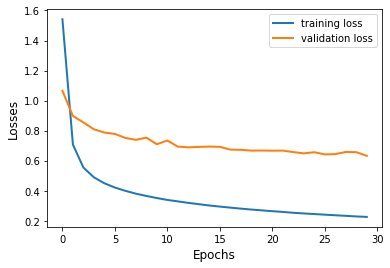

In [64]:
plot_losses(train_losses, val_losses)

On observe sur nos entrainements que la courbe de validation se stabilise avant d'augmenter sur les dernières époques. 

Cela est dû à l'arrêt de l'entrainement par la contrainte sur la distance avec la meilleure époque. Nous pouvions continuer à entrainer le modèle encore sur d'autres époques pour observer l'augmentation significative du cout sur le validation set.

## 4 - Predictions du modèle sur le test set

In [65]:
# Evalue le modèle sur le testset
def predict(model, test_dataloader):

    labels_l = []
    preds_l = []
    
    # Met de modèle en mode evaluation
    model.eval()
    
    # Boucle de tests
    with torch.no_grad():
        for i, batch in enumerate(test_dataloader):
            data, labels = batch
            # Transfert sur le GPU si disponible
            if torch.cuda.is_available():
                data, labels = data.cuda(), labels.cuda()
            labels_l.extend(labels.tolist())
            
            preds = model(data)
            preds = torch.argmax(preds, dim=1)
            preds_l.extend(preds.tolist())
    
    return labels_l, preds_l

In [66]:
train_labels, train_preds = predict(network, train_dataloader)
val_labels, val_preds = predict(network, val_dataloader)
test_labels, test_preds = predict(network, test_dataloader)

In [67]:
print(classification_report(train_labels, train_preds, target_names=COMMANDS))
print(classification_report(val_labels, val_preds, target_names=COMMANDS))
print(classification_report(test_labels, test_preds, target_names=COMMANDS))

              precision    recall  f1-score   support

         yes       0.90      0.96      0.93      3027
          no       0.96      0.89      0.92      2960

    accuracy                           0.93      5987
   macro avg       0.93      0.93      0.93      5987
weighted avg       0.93      0.93      0.93      5987

              precision    recall  f1-score   support

         yes       0.81      0.87      0.84       495
          no       0.87      0.80      0.83       504

    accuracy                           0.83       999
   macro avg       0.84      0.84      0.83       999
weighted avg       0.84      0.83      0.83       999

              precision    recall  f1-score   support

         yes       0.81      0.88      0.85       522
          no       0.86      0.78      0.82       477

    accuracy                           0.83       999
   macro avg       0.84      0.83      0.83       999
weighted avg       0.83      0.83      0.83       999



### La lecture du rapport
- La précision des prédictions nous permet de considérer la capacité du modèle à prédire précisément un label (prédiction correcte sur l'ensemble des prédictions du label).
- Le recall nous permet de considérer la capacité à reconnaitre un label (proportion du label ayant été prédit). 
- Le f1-score est une mesure liant la précision et le recall. 

Le f1-score de ce modèle est au dessus de 0.8 pour les 3 ensembles. Il est supérieur sur le train set car c'est sur lui qu'il s'entraine et similaire entre le test et la validation comme il ne s'entraine pas dessus.

### Comparaison avec le meilleur modèle sauvegardé
Le modèle extrait ici est celui sauavegardé au plus bas de la fonction de coût pour le validation set.

In [69]:
# Téléchargement du meilleur modèle
best = Network(len(COMMANDS))
best.load_state_dict(torch.load(best_path))
best.eval()
best.select_device()
# Prédiction sur le meilleur modèle
train_labels, train_preds = predict(best, train_dataloader)
val_labels, val_preds = predict(best, val_dataloader)
test_labels, test_preds = predict(best, test_dataloader)

In [70]:
print(classification_report(train_labels, train_preds, target_names=COMMANDS))
print(classification_report(val_labels, val_preds, target_names=COMMANDS))
print(classification_report(test_labels, test_preds, target_names=COMMANDS))

              precision    recall  f1-score   support

         yes       0.90      0.96      0.93      3027
          no       0.96      0.89      0.92      2960

    accuracy                           0.93      5987
   macro avg       0.93      0.93      0.93      5987
weighted avg       0.93      0.93      0.93      5987

              precision    recall  f1-score   support

         yes       0.81      0.87      0.84       495
          no       0.87      0.80      0.83       504

    accuracy                           0.83       999
   macro avg       0.84      0.84      0.83       999
weighted avg       0.84      0.83      0.83       999

              precision    recall  f1-score   support

         yes       0.81      0.88      0.85       522
          no       0.86      0.78      0.82       477

    accuracy                           0.83       999
   macro avg       0.84      0.83      0.83       999
weighted avg       0.83      0.83      0.83       999



## 5 - Conclusion
Pour réaliser ce modèle de réseaux de neurones, nous avons rencontré des difficultés.

Tout d'abord le modèle par lequel nous avions commencé comportait une structure trop complexe et un learning rate trop grand. Ces deux défauts apportait respectivement un sur-entrainement dès les premières époques et une courbe des coût fluctuante (le coût oscillant sur les gradients à cause de trop grand pas).

Ensuite nous avions un manque de données dans le premier dataset que nous avions considéré qui rendait le modèle peu précis (maximum 0.4 de f1-score).

En choisisant un dataset plus large et en nous limitant à 2 classes, nous nous sommes placé dans des conditions plus favorables pour notre construction de réseaux de neurones.

Notre modèle s'entraine correctement sur les 2 mots clé proposé ("yes", "no") et nous tournons autour d'un coût minimal sur la validation de 0.6 et un f1-score de 0.8.

Notre modèle peut s'adapter à une étude sur d'autres mots-clés du dataset par le cnagement du tableau COMMANDS. Nos entrainement sur de plus large liste devenaient moins performant et nécessitaient une révision du learning rate.

## 6 - Perspectives
Les améliorations possibles que nous envisageons sont l'augmentation de la taille du dataset ou le traitement des données sur le bruit de fond pour limité l'apprentissage de celui-ci.